## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [74]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [75]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [76]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [77]:
unique_users= df.user_id.nunique()
unique_users

290584

d. The proportion of users converted.

In [78]:
df.query('converted==1').user_id.nunique()/unique_users

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [79]:
df.query("group=='treatment'&landing_page!='new_page'|landing_page=='new_page' & group!='treatment'").count()['user_id']


3893

f. Do any of the rows have missing values?

In [80]:
#No missing values in any row
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [81]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))]

In [82]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [83]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [84]:
#retrieve duplicate rows 
df2[df2['user_id'].duplicated(keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [ ]:
#The cell above shows the information of the duplicate rows.

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [85]:
#rows number before dropping the duplicate row
df2.shape[0]

290585

In [86]:
#drop the duplicate row and verify the change
df2.drop(1899, inplace=True)
df2.shape[0]

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [87]:
#find the mean of converted column
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [88]:
df2.query("group == 'control'")['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [89]:
df2.query("group == 'treatment'")['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [90]:
df2.query("landing_page == 'new_page'")['user_id'].count()/df2.shape[0]

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

As shown above, the probability of converting when using the new page is 11.88%, while the conversion rate when using the old page is 12.04%.
So, the conversion rate of the control group is higher than the treatment group. Thus, we cannot conclude that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} <= p_{old}$$


$$H_1: p_{new}> p_{old}$$




`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [91]:
p_new=df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [92]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [93]:
treatment_df = df2.query("group =='treatment'")
n_new = treatment_df.user_id.nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [94]:
control_df = df2.query("group =='control'")
n_old = control_df.user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [136]:
new_page_converted = np.random.binomial(1,p_new,n_new).mean()
new_page_converted

0.1187598926433143

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [153]:
old_page_converted = np.random.binomial(1,p_old,n_old).mean()
old_page_converted

0.1202210994396795

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [154]:
#p_new - p_old under the null.
p_new - p_old

0.0

In [155]:
new_page_converted-old_page_converted

-0.0014612067963652026

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [160]:
p_diffs=[]
for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new).mean()
    old_page_converted = np.random.binomial(1,p_old,n_old).mean()
    p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

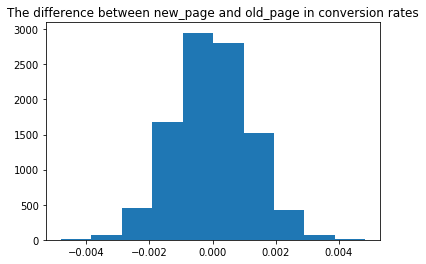

In [161]:
# convert to numpy array
p_diffs = np.array(p_diffs)
# plot distribution
plt.hist(p_diffs);


plt.title('The difference between new_page and old_page in conversion rates');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

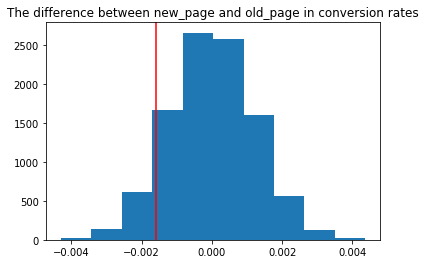

In [162]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0,p_diffs.std(),p_diffs.size)

# plot null distribution
plt.hist(null_vals);
plt.title('The difference between new_page and old_page in conversion rates');

#the actual difference observed in ab_data.csv
obs_diff = df2.query("landing_page == 'new_page'").converted.mean() -  df2.query("landing_page == 'old_page'").converted.mean() 

# plot line for observed statistic
plt.axvline(x=obs_diff,color='red');


In [163]:
# compute p value
(null_vals>obs_diff).mean()

0.90639999999999998

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

We've just computed the p-value ( The probability of observing our statistic or a more extreme statistic from the null hypothesis). 
Since the p-value in our example is 0.9064, and when comparing it to our Type I error threshold ( alpha - α )( Type I error rate of 5% ), we found out that the p-value is greater than Type I error. So, we failed to reject the null hypothesis and conduce that the old page is better than the new page.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [164]:
import statsmodels.api as sm

old_p_df=df2.query("landing_page=='old_page'")
new_p_df=df2.query("landing_page=='new_page'")

convert_old = old_p_df.converted.sum()
convert_new = new_p_df.converted.sum()
n_old = old_p_df.shape[0]
n_new = new_p_df.shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [165]:
#reterive the test statistic for the z-test and p-value for the z-test
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative ='smaller')

print("z_score =",z_score)
print("p_value =",p_value)


z_score = 1.31092419842
p_value = 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- The z-score represents the number of standard deviations either above or below the mean a data point is. The p-value is 0.905, and it is higher than the Type I error(0.05). The previous calculations substantiate the findings in parts j. and k, which indicate the failure to reject the null hypothesis.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since there are just two possible outcomes (either a conversion or no conversion), logistic regression is the appropriate regression approach to be used.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [166]:
#add an intercept column
df2['intercept']=1
#add a dummy variable column 
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [167]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

#fit the model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [168]:
#use these lines of code to create your own chisqprob function since it has been removed from the library
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 06 Dec 2020   Pseudo R-squ.:               8.077e-06
Time:                        18:36:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value associated with ab_page is 0.19, and it differs from the p-value that has extracted in Part II. But both of the p-values are greater than the significance level, and that can be a strong claim that the old page is better than the new page since we failed to reject the null hypothesis.

The reason behind the differentiation between p-values in the two parts is the null and alternative hypotheses associated with each part as shown below:

Hypothesis in Part II :
$$H_0: p_{new} <= p_{old}$$
$$H_1: p_{new}> p_{old}$$

Hypothesis in Part III (for the regression model ) :
$$H_0: p_{new} = p_{old}$$
$$H_1: p_{new}!= p_{old}$$


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Some factors may affect the conversion rate, such as visiting day and user age, and considering these factors may cause a significant statistical impact leads to more accurate decisions.

However, one of the disadvantages that may occur when adding additional terms into the regression model is Multi-collinearity. It occurs when the model includes multiple variables correlated to each other, and it makes the coefficients of the variables unstable.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [169]:
#load a dataset
countries_df=pd.read_csv('countries.csv')

countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [170]:
#join columns of the two dataFrames
merged_df=df2.set_index('user_id').join(countries_df.set_index('user_id'), how='inner')

merged_df.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [171]:
#find all possible values of the country variable
merged_df.country.unique()


array(['US', 'CA', 'UK'], dtype=object)

In [172]:
#create dummy variables
merged_df[['US', 'CA']] = pd.get_dummies(merged_df['country'])[['US', 'CA']]
merged_df.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,US,CA
user_id,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,1,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,1,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,1,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,1,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [173]:
#fit the model and obtain the results
logit_mod2 = sm.Logit(merged_df['converted'],merged_df[['intercept','ab_page','US','CA']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 06 Dec 2020   Pseudo R-squ.:               2.323e-05
Time:                        18:39:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

As shown above, the p-value associated with each country is higher than the threshold(0.05), which indicates that countries don’t have a scientific significance on the conversion rate.

In [174]:
#fit another model after creating columns for the interaction variables (page and country)
merged_df['US_page'] = merged_df['ab_page'] * merged_df['US']
merged_df['CA_page'] = merged_df['ab_page'] * merged_df['CA']


logit_mod3 = sm.Logit(merged_df['converted'], merged_df[['intercept','ab_page','US','US_page','CA','CA_page']])

#obtain the results
results3 = logit_mod3.fit()
results3.summary()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 06 Dec 2020   Pseudo R-squ.:               3.482e-05
Time:                        18:40:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
US             0.0057      0.019      0.306      0.760      -0.031       0.043
US_page       -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
CA_page       -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

The p-values for the interaction variables are higher than Type 1 error threshold. 
So, based on the above results, we can conclude that there are no significant effects on conversion rates when considering the interaction between page and country.


In conclusion, after conducting A/B tests and using probabilities and regression models to prove the new page implementation effect, we failed to reject the null hypothesis, and we proved that there is no sufficient evidence to conclude that the new treatment page leads to more conversions.


In [175]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0